In [63]:
import sys
sys.path.append('../')

import time
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
import utils.preprocessing
import glob
import pathlib
import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from pytorch.model import UNet, FCRN_A, ConvAutoencoder, ConvVAE
from pytorch.looper import Looper
import research.pytorch.utils as torch_utils
from pytorch.utils import RegressionDataset, get_count, SegmentationDataset, ClassificationDataset, SimpleDataset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm


def display_img(img):
    fig, ax = plt.subplots(figsize=(10, 20));
    plt.imshow(img, cmap="gray");

In [64]:
ds = ClassificationDataset("../data/tilted_detection_data/good/output", "../data/tilted_detection_data/bad/output")
lengths = (int(len(ds)*0.9), len(ds) - int(len(ds)*0.9))
print(lengths)
train, val = torch.utils.data.random_split(ds, lengths)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = torch.nn.Linear(num_ftrs, 2)

model = model.to(device)

model = torch.nn.DataParallel(model)

(1800, 200)


In [65]:
label_map = {0: 'Good', 1: 'Bad'}


In [66]:
torch.cat(3*[img], dim=1).shape

torch.Size([8, 3, 256, 256])

In [67]:
img = torch.randn(8,1,256,256).to(device)
out = model(torch.cat(3*[img], dim=1))
torch.argmax(out, dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [68]:
train_loader = DataLoader(train, batch_size=8,
                        shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=1,
                        shuffle=True, num_workers=0)
# initialize loss, optimized and learning rate scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
training_loss = []
validation_loss = []

In [221]:
best_loss = np.infty
num_epochs = 30
# counter for early stopping
counter = 0

for epoch in trange(num_epochs):
    train_loss = 0
    val_loss = 0
    acc=0
    for x, y in tqdm(train_loader):
        model.train()
        x = x.repeat(1,3,1,1).to(device)
        y = y.long().to(device)
        # forward
        out = model(x)
        loss = criterion(out, y)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    for x, y in val_loader:
        model.eval()
        x = x.repeat(1,3,1,1).to(device)
        y = y.long().to(device)
        # forward
        out = model(x)
        loss = criterion(out, y)
        # backward
        val_loss += loss.item()
        acc+=torch.mean(1  - torch.abs( torch.argmax(out, dim=1) - y.float())).item()
        # log
    
    training_loss.append(train_loss)
    validation_loss.append(val_loss)

    print('Epoch [{}/{}], Train loss:{:.4f}, Validation loss:{:.4f}, Acc: {}'
          .format(epoch+1, num_epochs, train_loss, val_loss, acc / len(val_loader)))
    
    if val_loss >= best_loss:
        counter += 1
        if counter > 3:
            break
    else:
        best_loss = val_loss
        torch.save(model.state_dict(), 'pytorch/trained/tilt_detection/pretrained_classifier.pth')



Epoch [1/30], Train loss:87.4147, Validation loss:81.2066, Acc: 0.815



Epoch [2/30], Train loss:86.7358, Validation loss:75.3863, Acc: 0.84



Epoch [3/30], Train loss:90.5310, Validation loss:73.0337, Acc: 0.855



Epoch [4/30], Train loss:85.8201, Validation loss:73.8011, Acc: 0.825



Epoch [5/30], Train loss:85.9755, Validation loss:73.1626, Acc: 0.825



Epoch [6/30], Train loss:83.0145, Validation loss:69.7389, Acc: 0.845



Epoch [7/30], Train loss:78.9417, Validation loss:70.7703, Acc: 0.855



Epoch [8/30], Train loss:82.5429, Validation loss:81.3285, Acc: 0.835



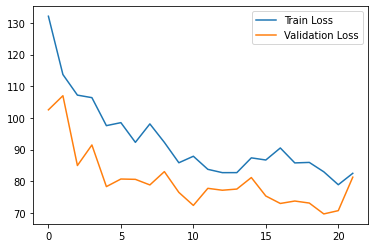

In [222]:
plt.plot(training_loss, label='Train Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()

In [223]:
test_ds = ClassificationDataset("../data/tilted_detection_data/test_good", "../data/tilted_detection_data/test_bad")
test_loader = DataLoader(test_ds, batch_size=1,
                        shuffle=True, num_workers=0)

predictions = []
true = []
mistakes = []

for x,y in test_loader:
    pred = torch.argmax(model(x.repeat(1,3,1,1)).cpu()).item()
    true.append(y.item())
    predictions.append(pred)
    if pred != y.item():
        mistakes.append((x, y.item(), pred))
    

In [231]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
print(classification_report(true, predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        25
         1.0       0.83      1.00      0.91        25

    accuracy                           0.90        50
   macro avg       0.92      0.90      0.90        50
weighted avg       0.92      0.90      0.90        50



In [225]:
confusion_matrix(true, predictions)


array([[20,  5],
       [ 0, 25]], dtype=int64)

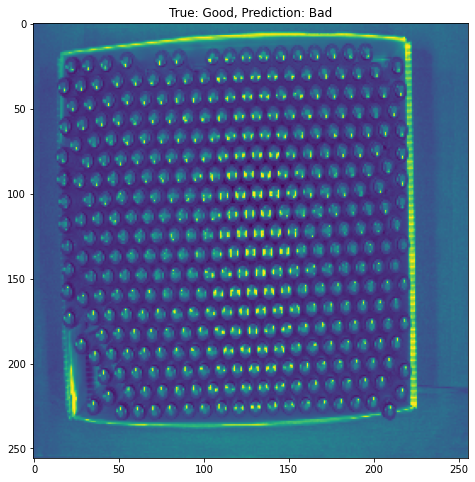

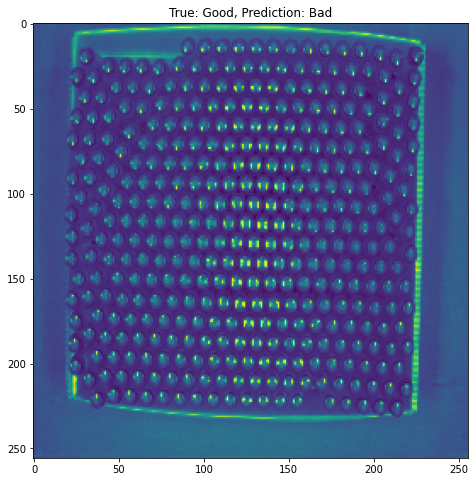

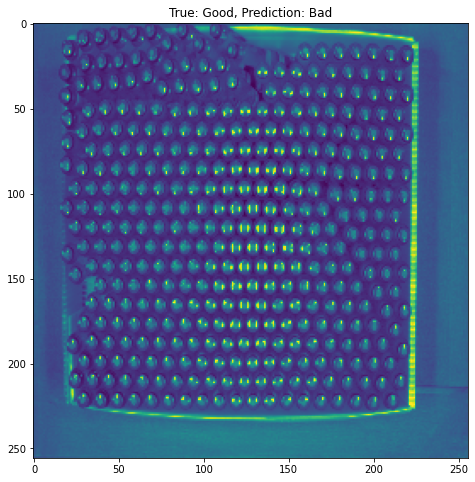

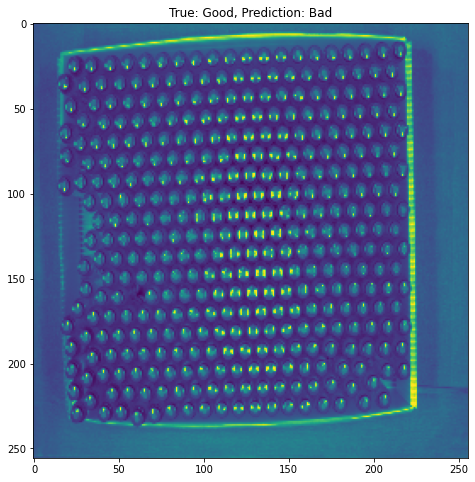

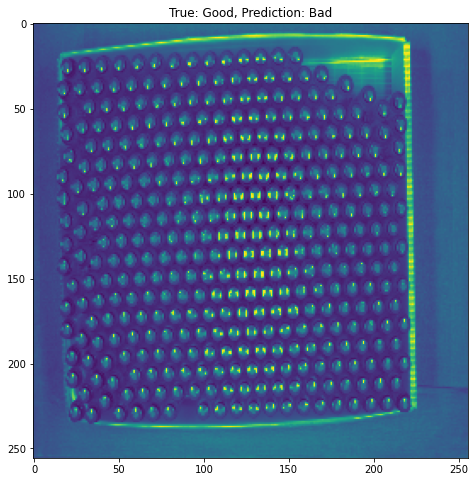

In [226]:
for img, t, pred in mistakes:
    plt.figure(figsize=(8,8))
    plt.title(f'True: {label_map[t]}, Prediction: {label_map[pred]}')
    plt.imshow(img.detach().cpu()[0][0])